###Задание.
####Для реализованной в методичке модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом.
####Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев).
####Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).

In [1]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [4]:
#функция, реализующую предсказание в градиентном бустинге

def gb_predict(X, trees_list, eta):
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )
    return predictions

In [5]:
#Функция среднеквадратичной ошибки

def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [6]:
#Функция потерь L2

def residual(y, z):
    return - (z - y)

In [7]:
#Функция обучения градиентного бустинга

def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [8]:
#Функция построения графиков зависимости ошибки от количества деревьев при разных значениях шага градиента

def get_plot(n_trees, train_err, test_err, param, name_param):
    fif, ax= plt.subplots(figsize = (16, 18))
    plt.subplot(2,1,1)
    for key in train_err.keys():
      plt.plot(list(range(n_trees)), train_err[key], label=f'{name_param}={param[key]}')
    plt.title(f'Ошибка на тренировочной выборке в \nзависимости от параметров: число деревьев и {name_param}')
    plt.xlabel('Количество деревьев')
    plt.ylabel('Величина ошибки')
    plt.legend(loc='upper right')
        
    plt.subplot(2,1,2)
    for key in test_err.keys():
      plt.plot(list(range(n_trees)), test_err[key], label=f'{name_param}={param[key]}')
    plt.title(f'Ошибка на тестовой выборке в \nзависимости от параметров: число деревьев и {name_param}')
    plt.xlabel('Количество деревьев')
    plt.ylabel('Величина ошибки')
    plt.legend()
    plt.show()

###Теперь обучим несколько моделей с разным шагом градиента. Установим изначально количество деревьев - 50.

In [21]:
n_trees = 50
max_depth = 2
eta = [1.0, 0.5, 0.2, 0.1]
all_train_errors = {}
all_test_errors = {}
all_eta = {}
for i in eta:
  trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, i)
  all_train_errors[i] = train_errors
  all_test_errors[i] = test_errors
  all_eta[i] = i  

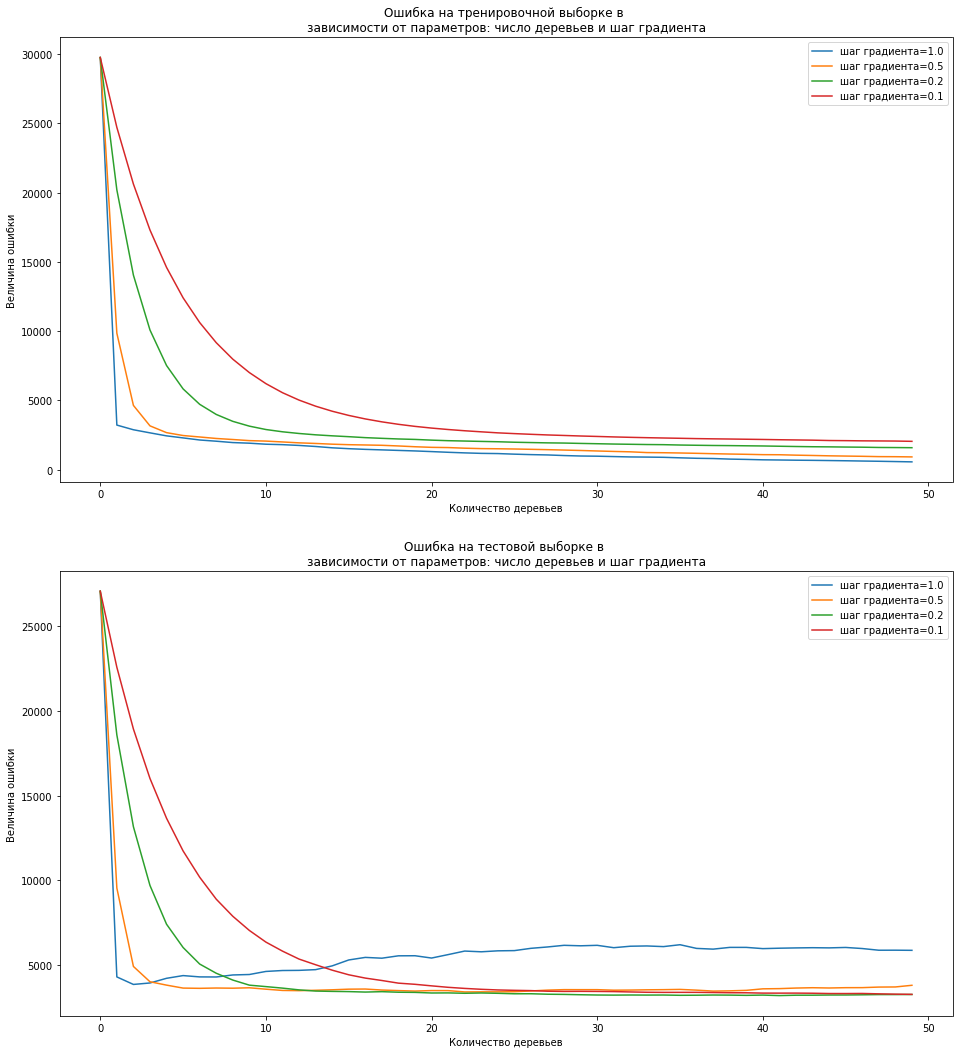

In [22]:
get_plot(n_trees, all_train_errors, all_test_errors, all_eta, 'шаг градиента')

###как видно из графиков, со значительным увеличением количества деревьев качество предсказаний не улучшается.
###определим, при каком шаге в данных моделях достигнута минимальная ошибка предсказания

In [23]:
min(all_test_errors[1]), min(all_test_errors[0.5]), min(all_test_errors[0.2]), min(all_test_errors[0.1])

(3850.257199719928, 3407.7010949296287, 3192.150159952852, 3264.1078590297134)

###найдём порядковый номер дерева, в котором ошибка минимальна

In [24]:
res = [i for i, j in enumerate(all_test_errors[0.2]) if j == min(all_test_errors[0.2])]
res

[41]

###минимальная ошибка в данных моделях - при шаге 0,2 и количестве деревьев - 42


###Теперь обучим несколько моделей с разной глубиной деревьев с шагом 0,2 и количеством деревьев 42

In [25]:
n_trees = 42
eta = 0.2
max_depth = [2, 3, 4, 5]
all_train_errors = {}
all_test_errors = {}
all_max_depth = {}
for depth in max_depth:
  trees, train_errors, test_errors = gb_fit(n_trees, depth, X_train, X_test, y_train, y_test, eta)
  all_train_errors[depth] = train_errors
  all_test_errors[depth] = test_errors
  all_max_depth[depth] = depth  

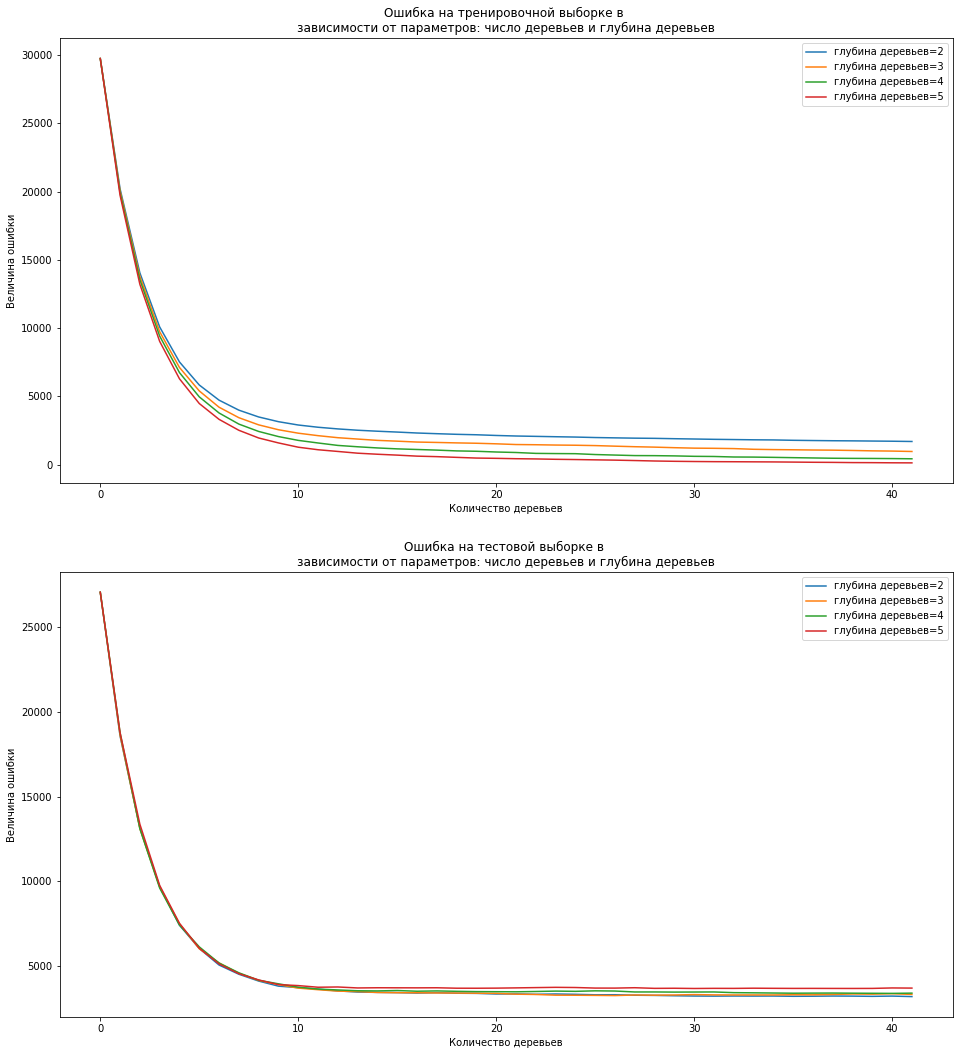

In [26]:
get_plot(n_trees, all_train_errors, all_test_errors, all_max_depth, 'глубина деревьев')

###из графиков видно, что с увеличением глубины деревьев качество предсказания не улучшается

###определим при какой глубине деревьев в данных моделях достигается минимальная ошибка

In [28]:
min(all_test_errors[2]), min(all_test_errors[3]), min(all_test_errors[4]), min(all_test_errors[5])

(3192.150159952852, 3251.6324847453925, 3381.4438639145487, 3670.231559421753)

In [29]:
res = [i for i, j in enumerate(all_test_errors[2]) if j == min(all_test_errors[2])]
res

[41]

###делаем вывод, что в данных моделях наилучшими параметрами для получения минимальной ошибки предсказания являются: шаг - 0,2, глубина деревьев - 2, количество деревьев - 42